In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# !pip install requests pandas schedule

In [12]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta
import os
from tqdm.notebook import tqdm  # Better for Colab/Kaggle environments

# Open-Meteo API endpoint for historical weather data
HISTORICAL_URL = "https://archive-api.open-meteo.com/v1/archive"

# List of 20 Indian cities with their coordinates (lat, lon)
CITIES = {
    "Mumbai": {"lat": 19.0760, "lon": 72.8777},
    "Delhi": {"lat": 28.7041, "lon": 77.1025},
    "Bangalore": {"lat": 12.9716, "lon": 77.5946},
    "Hyderabad": {"lat": 17.3850, "lon": 78.4867},
    "Chennai": {"lat": 13.0827, "lon": 80.2707},
    "Kolkata": {"lat": 22.5726, "lon": 88.3639},
    "Pune": {"lat": 18.5204, "lon": 73.8567},
    "Ahmedabad": {"lat": 23.0225, "lon": 72.5714},
    "Jaipur": {"lat": 26.9124, "lon": 75.7873},
    "Lucknow": {"lat": 26.8467, "lon": 80.9462},
    "Kanpur": {"lat": 26.4499, "lon": 80.3319},
    "Nagpur": {"lat": 21.1458, "lon": 79.0882},
    "Indore": {"lat": 22.7196, "lon": 75.8577},
    "Thane": {"lat": 19.2183, "lon": 72.9781},
    "Bhopal": {"lat": 23.2599, "lon": 77.4126},
    "Visakhapatnam": {"lat": 17.6868, "lon": 83.2185},
    "Patna": {"lat": 25.5941, "lon": 85.1376},
    "Vadodara": {"lat": 22.3072, "lon": 73.1812},
    "Ghaziabad": {"lat": 28.6692, "lon": 77.4538},
    "Ludhiana": {"lat": 30.9010, "lon": 75.8573}
}

def fetch_historical_data(city_name, lat, lon, start_date, end_date):
    """
    Fetch historical weather data for a given location and time period
    
    Parameters:
    city_name (str): Name of the city
    lat (float): Latitude
    lon (float): Longitude
    start_date (str): Start date in format 'YYYY-MM-DD'
    end_date (str): End date in format 'YYYY-MM-DD'
    
    Returns:
    dict: Weather data
    """
    # Weather variables to request 
    # For full list see: https://open-meteo.com/en/docs/historical-weather-api
    weather_variables = [
        "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean",
        "relative_humidity_2m_max", "relative_humidity_2m_min", "relative_humidity_2m_mean",
        "rain_sum", "precipitation_hours", "windspeed_10m_max", "windspeed_10m_mean",
        "windgusts_10m_max", "winddirection_10m_dominant", "shortwave_radiation_sum",
        "cloudcover_mean"
    ]
    
    # Build parameters
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ",".join(weather_variables),
        "timezone": "auto"
    }
    
    try:
        response = requests.get(HISTORICAL_URL, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Process the data
        return process_data(data, city_name)
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {city_name}: {e}")
        return None

def process_data(data, city_name):
    """Process and structure the API response data"""
    if not data or "daily" not in data:
        return None
    
    daily = data["daily"]
    processed_data = []
    
    # Extract timezone for reference
    timezone = data.get("timezone", "UTC")
    
    # Process each day's data
    for i in range(len(daily["time"])):
        day_data = {
            "city": city_name,
            "date": daily["time"][i],
            "timezone": timezone,
            "temperature_max": daily["temperature_2m_max"][i],
            "temperature_min": daily["temperature_2m_min"][i],
            "temperature_mean": daily["temperature_2m_mean"][i],
            "humidity_max": daily["relative_humidity_2m_max"][i],
            "humidity_min": daily["relative_humidity_2m_min"][i],
            "humidity_mean": daily["relative_humidity_2m_mean"][i],
            "rain_sum": daily["rain_sum"][i],
            "precipitation_hours": daily["precipitation_hours"][i],
            "wind_speed_max": daily["windspeed_10m_max"][i],
            "wind_speed_mean": daily["windspeed_10m_mean"][i],
            "wind_gusts_max": daily["windgusts_10m_max"][i],
            "wind_direction": daily["winddirection_10m_dominant"][i],
            "radiation_sum": daily["shortwave_radiation_sum"][i],
            "cloudcover_mean": daily["cloudcover_mean"][i]
        }
        processed_data.append(day_data)
    
    return processed_data

def collect_historical_data(days_back=30, output_file="indian_cities_weather.csv"):
    """
    Collect historical weather data for all cities for a specified period
    
    Parameters:
    days_back (int): Number of days back to collect data
    output_file (str): Output CSV filename
    
    Returns:
    pandas.DataFrame: Collected weather data
    """
    all_data = []
    
    # Calculate date range
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days_back)
    
    # Format dates for API
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    
    print(f"Collecting historical weather data for {len(CITIES)} Indian cities")
    print(f"Period: {start_date_str} to {end_date_str}")
    
    # Collect data for each city
    for city_name, coords in tqdm(CITIES.items(), desc="Cities"):
        print(f"\nFetching data for {city_name}...")
        
        city_data = fetch_historical_data(
            city_name,
            coords["lat"],
            coords["lon"],
            start_date_str,
            end_date_str
        )
        
        if city_data:
            all_data.extend(city_data)
            print(f"Successfully collected {len(city_data)} days of data for {city_name}")
        else:
            print(f"Failed to collect data for {city_name}")
        
        # Brief pause to avoid overwhelming the API
        time.sleep(0.5)
    
    # Convert to DataFrame and save
    if all_data:
        df = pd.DataFrame(all_data)
        
        # Save to CSV
        df.to_csv(output_file, index=False)
        print(f"\nSuccessfully collected {len(all_data)} total data points")
        print(f"Data saved to {output_file}")
        
        return df
    else:
        print("No data was collected")
        return None


# Example usage - uncomment to run in notebook:
days_back = 180  # Adjust as needed
output_file = 'indian_cities_weather.csv'

# Collect data
df = collect_historical_data(days_back=days_back, output_file=output_file)

Period: 2024-09-10 to 2025-03-09


Cities:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching data for Mumbai...
Successfully collected 181 days of data for Mumbai

Fetching data for Delhi...
Successfully collected 181 days of data for Delhi

Fetching data for Bangalore...
Successfully collected 181 days of data for Bangalore

Fetching data for Hyderabad...
Successfully collected 181 days of data for Hyderabad

Fetching data for Chennai...
Successfully collected 181 days of data for Chennai

Fetching data for Kolkata...
Successfully collected 181 days of data for Kolkata

Fetching data for Pune...
Successfully collected 181 days of data for Pune

Fetching data for Ahmedabad...
Successfully collected 181 days of data for Ahmedabad

Fetching data for Jaipur...
Successfully collected 181 days of data for Jaipur

Fetching data for Lucknow...
Successfully collected 181 days of data for Lucknow

Fetching data for Kanpur...
Successfully collected 181 days of data for Kanpur

Fetching data for Nagpur...
Successfully collected 181 days of data for Nagpur

Fetching data for Ind

# Different Ways to visualize Time-Series Data

In [11]:
def analyze_data(df):
    """
    Perform basic analysis on the collected weather data
    
    Parameters:
    df (pandas.DataFrame): Weather data DataFrame
    """
    if df is None or len(df) == 0:
        print("No data available for analysis")
        return
    
    # Convert date to datetime for proper sorting
    df['date'] = pd.to_datetime(df['date'])
    
    # Group by city
    city_stats = df.groupby('city').agg({
        'temperature_max': ['max', 'mean'],
        'temperature_min': ['min', 'mean'],
        'humidity_mean': 'mean',
        'rain_sum': 'sum',
        'wind_speed_max': 'max',
        'cloudcover_mean': 'mean'
    })
    
    # Rename columns for clarity
    city_stats.columns = [
        'highest_max_temp', 'avg_max_temp',
        'lowest_min_temp', 'avg_min_temp',
        'avg_humidity', 'total_rainfall',
        'max_wind_speed', 'avg_cloudcover'
    ]
    
    # Calculate temperature range
    city_stats['temp_range'] = city_stats['avg_max_temp'] - city_stats['avg_min_temp']
    
    # Sort by average temperature for display
    city_stats = city_stats.sort_values('avg_max_temp', ascending=False)
    
    # Display and return stats
    print("\n===== City Weather Statistics =====")
    print(city_stats)
    
    # Save stats to CSV
    stats_file = "city_weather_stats.csv"
    city_stats.to_csv(stats_file)
    print(f"\nStatistics saved to {stats_file}")
    
    return city_stats

def create_visualizations(df):
    """
    Generate visualizations for the weather data
    
    Parameters:
    df (pandas.DataFrame): Weather data DataFrame
    """
    if df is None or len(df) == 0:
        print("No data available for visualizations")
        return
    
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        
        # Ensure date is in datetime format
        df['date'] = pd.to_datetime(df['date'])
        
        # Set style
        sns.set(style="whitegrid")
        
        # 1. Temperature comparison across cities
        plt.figure(figsize=(14, 8))
        city_temps = df.groupby('city')['temperature_mean'].mean().sort_values(ascending=False)
        
        ax = sns.barplot(x=city_temps.index, y=city_temps.values)
        plt.title('Average Temperature by City (°C)', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.xlabel('City', fontsize=12)
        plt.ylabel('Average Temperature (°C)', fontsize=12)
        
        # Add values on top of bars
        for i, v in enumerate(city_temps.values):
            ax.text(i, v + 0.1, f"{v:.1f}", ha='center', fontsize=8)
            
        plt.tight_layout()
        plt.savefig('city_temperatures.png')
        plt.show()
        
        # 2. Rainfall comparison
        plt.figure(figsize=(14, 8))
        city_rain = df.groupby('city')['rain_sum'].sum().sort_values(ascending=False)
        
        ax = sns.barplot(x=city_rain.index, y=city_rain.values)
        plt.title('Total Rainfall by City (mm)', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.xlabel('City', fontsize=12)
        plt.ylabel('Total Rainfall (mm)', fontsize=12)
        
        # Add values on top of bars
        for i, v in enumerate(city_rain.values):
            ax.text(i, v + 0.5, f"{v:.1f}", ha='center', fontsize=8)
            
        plt.tight_layout()
        plt.savefig('city_rainfall.png')
        plt.show()
        
        # 3. Temperature trends for top 5 major cities
        plt.figure(figsize=(15, 8))
        
        # Select major cities
        major_cities = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai', 'Kolkata']
        city_data = df[df['city'].isin(major_cities)].copy()
        
        # Plot temperature trends
        for city in major_cities:
            city_df = city_data[city_data['city'] == city]
            plt.plot(city_df['date'], city_df['temperature_mean'], marker='o', markersize=4, linestyle='-', linewidth=2, label=city)
            
        plt.title('Temperature Trends for Major Cities', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Temperature (°C)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('temperature_trends.png')
        plt.show()
        
        # 4. Humidity vs Temperature heatmap
        plt.figure(figsize=(12, 10))
        
        # Create pivot table for heatmap
        city_climate = df.groupby('city').agg({
            'temperature_mean': 'mean',
            'humidity_mean': 'mean'
        }).reset_index()
        
        # Create heatmap data
        pivot_data = city_climate.pivot_table(
            index='city', 
            values=['temperature_mean', 'humidity_mean']
        )
        
        # Sort by temperature
        pivot_data = pivot_data.sort_values('temperature_mean', ascending=False)
        
        # Create heatmap
        sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
        plt.title('Temperature vs Humidity by City', fontsize=16)
        plt.tight_layout()
        plt.savefig('city_climate_heatmap.png')
        plt.show()
        
        # 5. Wind speed across cities
        plt.figure(figsize=(14, 8))
        wind_data = df.groupby('city').agg({
            'wind_speed_max': 'max',
            'wind_speed_mean': 'mean'
        }).sort_values('wind_speed_mean', ascending=False)
        
        wind_data.plot(kind='bar', figsize=(14, 8))
        plt.title('Wind Speed by City (km/h)', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.xlabel('City', fontsize=12)
        plt.ylabel('Wind Speed (km/h)', fontsize=12)
        plt.legend(['Maximum Wind Speed', 'Average Wind Speed'])
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('city_wind_speed.png')
        plt.show()
        
        print("Visualizations saved as PNG files and displayed")
        
    except ImportError:
        print("Matplotlib and/or seaborn not available. Install with: pip install matplotlib seaborn")



===== City Weather Statistics =====
               highest_max_temp  avg_max_temp  lowest_min_temp  avg_min_temp  \
city                                                                           
Thane                      40.0     33.453889             15.6     21.298333   
Mumbai                     37.6     31.952778             17.9     22.703333   
Vadodara                   37.4     31.498333             13.0     20.041111   
Ahmedabad                  36.8     30.997778             12.6     20.013333   
Pune                       37.0     30.819444             12.4     19.170556   
Nagpur                     36.8     30.698889             12.2     19.683333   
Visakhapatnam              35.9     30.468333             15.5     22.083333   
Hyderabad                  36.2     30.051111             15.5     20.705000   
Chennai                    36.5     30.033333             19.9     24.008889   
Kolkata                    34.3     28.740000             12.0     19.842778   
Ind

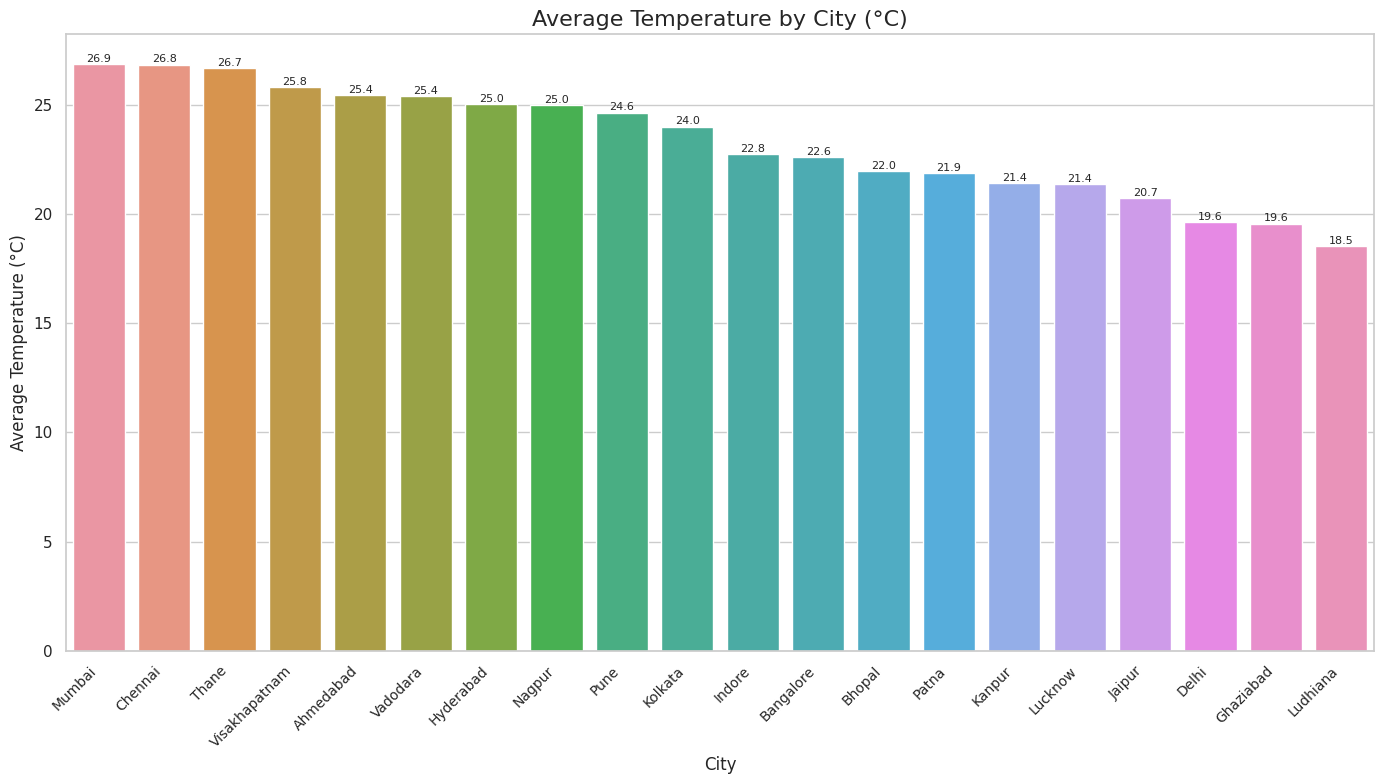

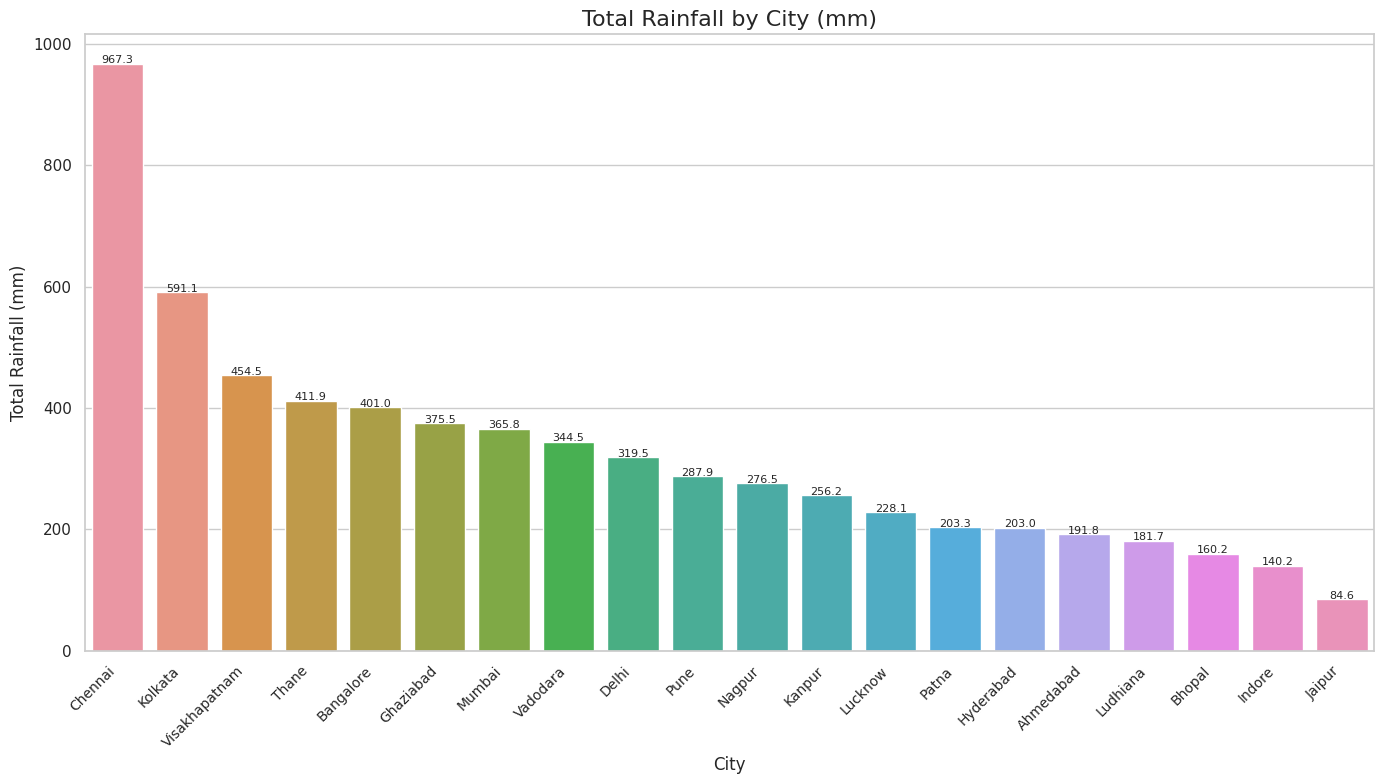

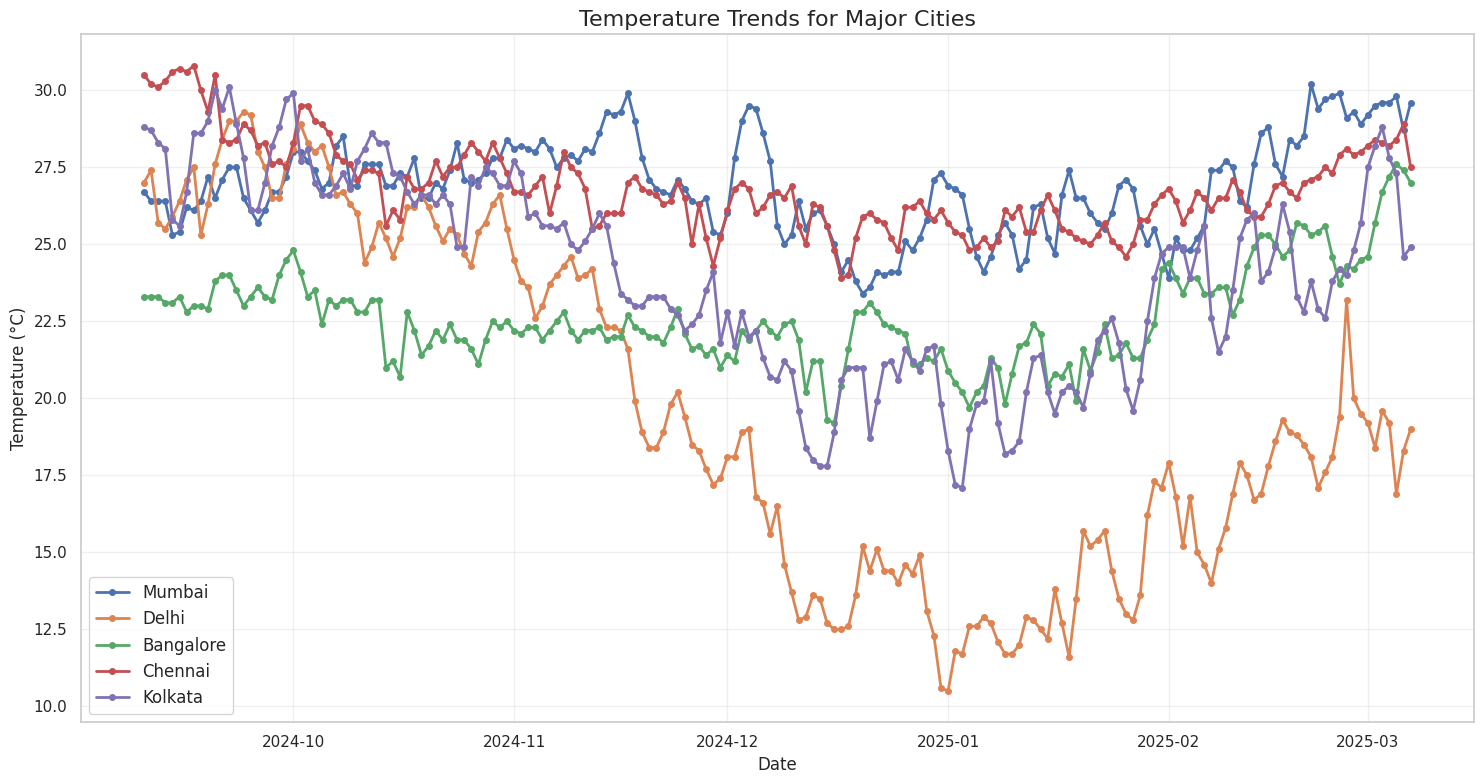

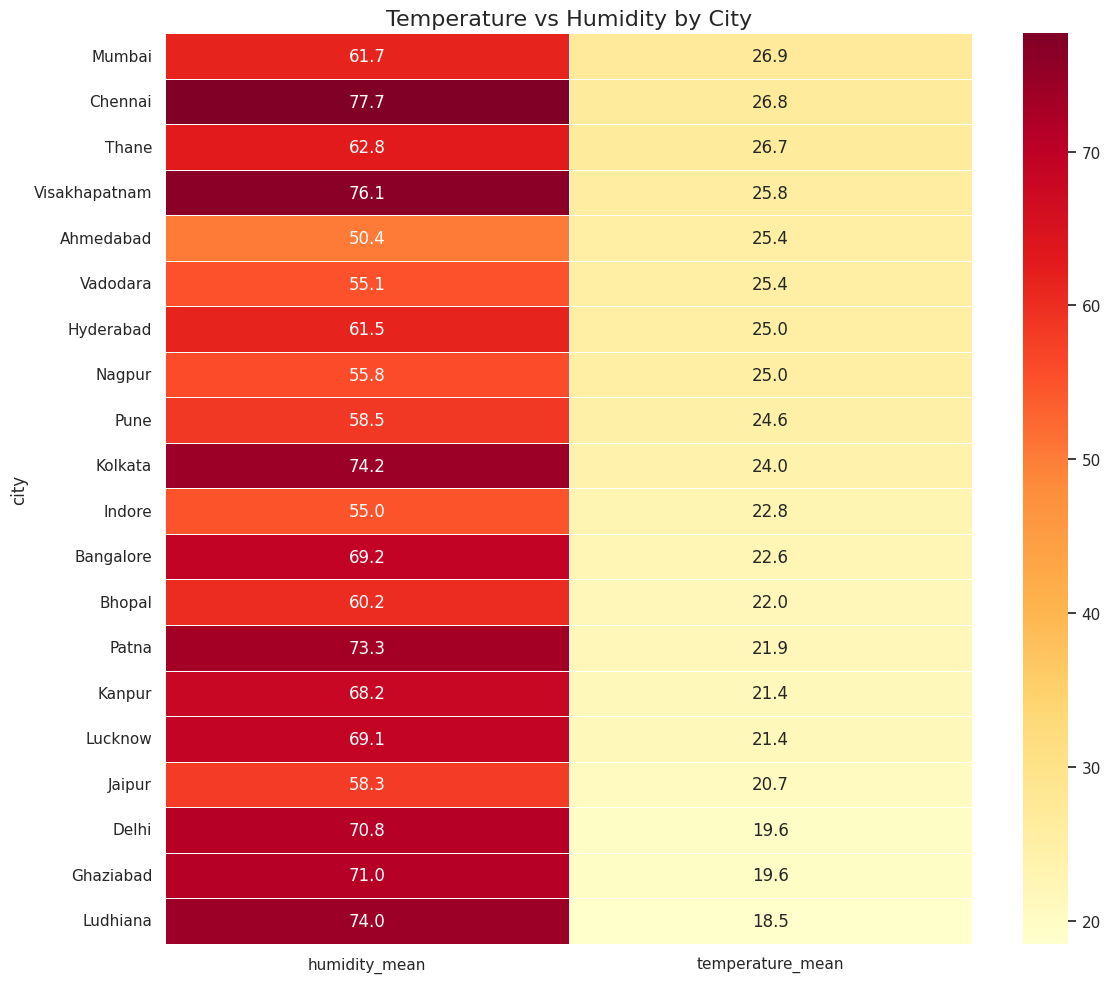

<Figure size 1400x800 with 0 Axes>

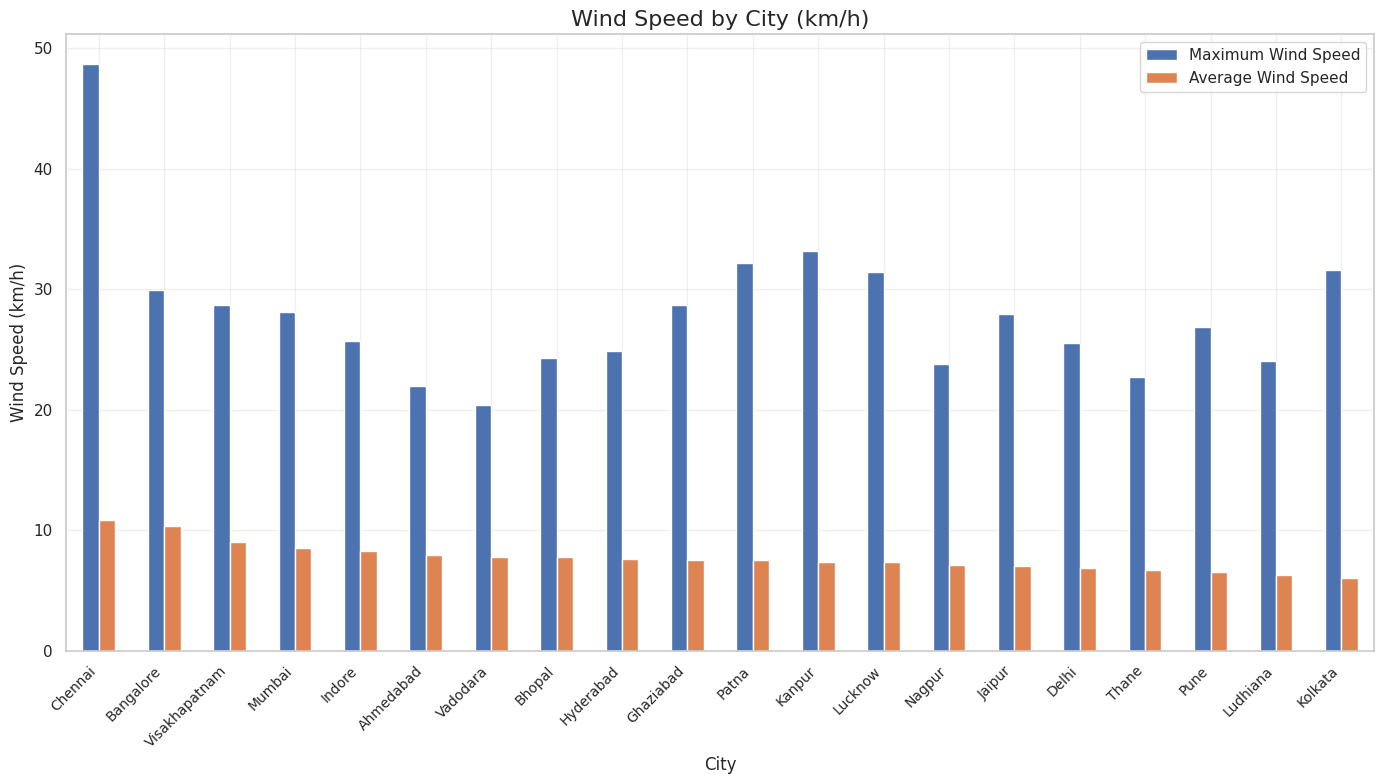

Visualizations saved as PNG files and displayed


In [13]:
# # If data was collected successfully, analyze and visualize
if df is not None:
    # Basic statistics
    city_stats = analyze_data(df)
    
    # Create visualizations
    create_visualizations(df)